In [190]:
import numpy as np
import scipy as sp
import pandas as pd
import streamlit
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
from rich.console import Console
import json
import os
import geopandas as gpd
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC


In [191]:
uni_list_url = "https://www.usnews.com/best-graduate-schools/top-science-schools/computer-science-rankings"
gimmeproxy_url = "https://gimmeproxy.com/api/getProxy"
geo_api_endpoint = "http://api.positionstack.com/v1/forward"
console = Console()
scroll_pause_time = 5 # время, которое будет ждать селениум, прежде, чем прокрутить страницу вниз, в секундах

[это помогло мне динамически менять ip адрес, поскольку веб-сервисы не любят, когда их данные пытаются скрейпить](https://stackoverflow.com/questions/28852057/change-ip-address-dynamically)
И да, это api

In [192]:
def get_ip():
    raw_proxy = json.loads(requests.get(gimmeproxy_url).text)
    target = raw_proxy["ip"]
    console.print(f"found this free proxy\n{raw_proxy}")
    console.print("got this brand new ip-adress\n{0}".format(target), style="bold green")
    return target

In [193]:
wd_instance = webdriver.Chrome(ChromeDriverManager().install())
options = webdriver.ChromeOptions()
options.add_argument('--proxy-server={}'.format(set(get_ip())))

[WDM] - ====== WebDriver manager ======
2022-06-05 18:21:24.047 INFO    WDM: ====== WebDriver manager ======
[WDM] - Current google-chrome version is 102.0.5005
2022-06-05 18:21:24.136 INFO    WDM: Current google-chrome version is 102.0.5005
[WDM] - Get LATEST chromedriver version for 102.0.5005 google-chrome
2022-06-05 18:21:24.138 INFO    WDM: Get LATEST chromedriver version for 102.0.5005 google-chrome
[WDM] - Driver [/Users/Rober/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache
2022-06-05 18:21:24.238 INFO    WDM: Driver [/Users/Rober/.wdm/drivers/chromedriver/mac64_m1/102.0.5005.61/chromedriver] found in cache
/var/folders/2m/2cdbvl6s55s3dq_58sct57n00000gn/T/ipykernel_73568/1773172436.py:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  wd_instance = webdriver.Chrome(ChromeDriverManager().install())


found this free proxy
{'supportsHttps': True, 'protocol': 'socks5', 'ip': '62.113.115.94', 'port': '16072', 'get': 
True, 'post': True, 'cookies': True, 'referer': True, 'user-agent': True, 'anonymityLevel': 
1, 'websites': {'example': True, 'google': False, 'amazon': False, 'yelp': False, 
'google_maps': False}, 'country': 'RU', 'unixTimestampMs': 1654441860580, 'tsChecked': 
1654441860, 'unixTimestamp': 1654441860, 'curl': 'socks5://62.113.115.94:16072', 'ipPort': 
'62.113.115.94:16072', 'type': 'socks5', 'speed': 10, 'otherProtocols': {}, 
'verifiedSecondsAgo': 626}

got this brand new ip-adress
62.113.115.94

In [194]:
def fetch_data(url: str):
    wd_instance.get(url)
    time.sleep(10)
    last_height = wd_instance.execute_script("return document.body.scrollHeight")
    time.sleep(1)
    y = 1000
    for timer in range(0,50):
        wd_instance.execute_script("window.scrollTo(0, "+str(y)+")")
        y += 1000  
        time.sleep(1)
        

    # console.print(wd_instance.page_source)
    return BeautifulSoup(wd_instance.page_source).find("table", class_="TableStacked__Container-sc-82ags4-0 bQkqOS" )
    # console.print(table, style="underline yellow")
    
def uni_serialize():
    raw_data = fetch_data(uni_list_url)
    target = []
    list_univs = []
    for uni in raw_data.find_all('div', class_="Box-w0dun1-0 cuHzbF")[:30]:
        list_univs.append([uni["name"], uni.p.text.split(', ')[0], uni.p.text.split(', ')[1]])
        # console.log(uni)
    # return [table.findAll("div", class_="Box-w0dun1-0 cuHzbF")]
    return pd.DataFrame(list_univs, columns = ['University', 'Location', 'State'])

def get_geolocation(uni_name):
    GEO_API_KEY = "7e5af99fd356a3a854e866c2f16064eb"
    # console.log("[geo]: request\n")
    # console.log(geo_api_endpoint + f"?access_key={GEO_API_KEY}&query={uni_name}")
    # console.log("[geo]: response\n")
    # console.log(json.loads(requests.get(url=geo_api_endpoint + f"?access_key={GEO_API_KEY}&query={uni_name} USA").text))
    target = list(filter(lambda x: x["country"] == "United States", json.loads(requests.get(url=geo_api_endpoint + f"?access_key={GEO_API_KEY}&query={uni_name}").text)["data"]))[0]
    return {"latitude": target["latitude"], "longitude": target["longitude"]}
    

def add_geo(df):
    geo_lat = [get_geolocation(_)["latitude"] for _ in df["University"]]
    geo_lon = [get_geolocation(_)["longitude"] for _ in df["University"]]
    
    df.insert(3, "Latitude", geo_lat, True)
    df.insert(4, "Longitude", geo_lon, True)
    return df
    

In [195]:
uni_data = uni_serialize()

получили базовую информацию об университетах с сайта. Добавим к этим данным их географическое положение через api [api.positionstack.com/v1](https://positionstack.com). Построим карту Америки и отметим на ней университеты, используя библиотеку geopandas. Я нашел в открытом доступе файлы с необходимыми для отображения карты Америки формами. [Источник](https://github.com/joncutrer/geopandas-tutorial/tree/master/data)

In [196]:
uni_data = add_geo(uni_data)

In [197]:
states = gpd.read_file("usa-states-census-2014.shp")
states.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


Говорят, что вузы западного побережья круче Восточных. Проверим гиппотезу

In [198]:
# штаты западного и восточного побережья
west = [states["STUSPS"][i] for i in range(len(states)) if 'est' in states["region"][i]] 
east = [states["STUSPS"][i] for i in range(len(states)) if 'ast' in states["region"][i]] 

тут я вспомнил, что нужно много строчек..

In [199]:
west_uni_avg = 0
west_uni_counter = 0
for i in uni_data:
    if i['state'] in west: 
        west_uni_avg + 

SyntaxError: invalid syntax (678013797.py, line 5)

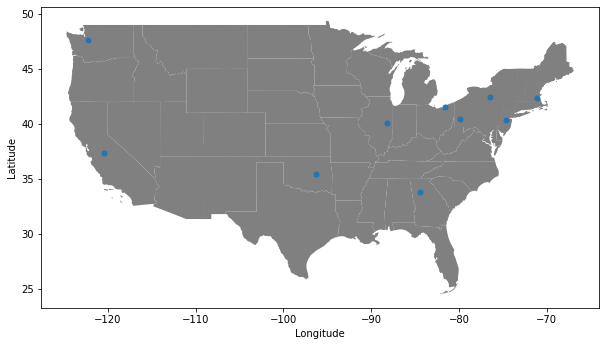

In [200]:
fig, ax = plt.subplots(figsize=(10,10))
states.plot(color="gray", ax=ax, )
uni_data.plot(x="Longitude", y="Latitude", kind="scatter", s=25, colormap="Blues", ax=ax)
plt.show()